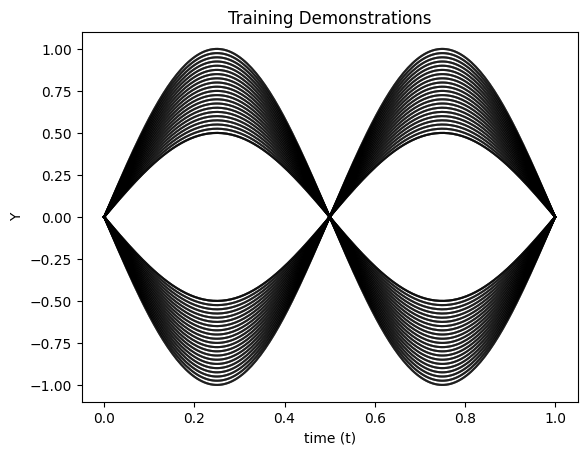

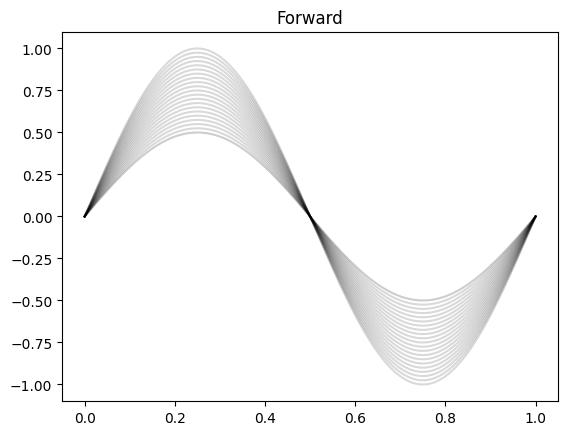

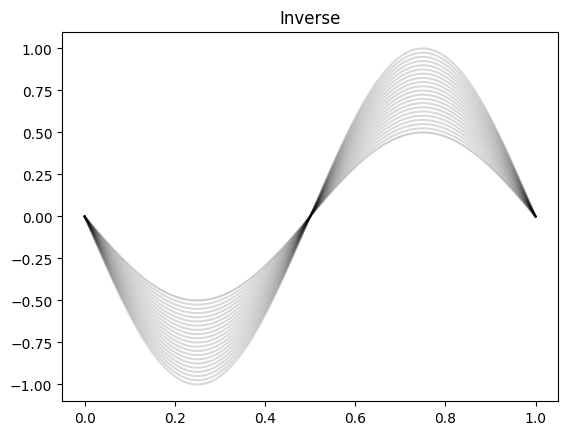

In [365]:
from cProfile import label
from re import X
from turtle import color
from sympy import li
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math
import importlib

import dual_enc_dec_cnmp as dual_enc_dec_cnmp
import utils
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

#params = np.array([[2,0],[2,0],[2,0],[2,0],[2,0],[-0.6,0.1],[-0.55, 0.16],[-0.5,0.23],[-0.45, 0.33],[-0.4,0.43]])
params = np.array([[20],[19.9],[19.7]])

num_demo = 64
X1, X2, Y1, Y2, validation_Y1, validation_Y2 = utils.generate_demonstrations(num_demo, time_len=200, params = params, plot_title='Training')

In [379]:
demo_data = [X1, X2, Y1, Y2]
d_x = 1
d_y1 = 1
d_y2 = 1
OBS_MAX = 5
d_N = num_demo
time_len = 200

validation_indices_1 = [i+1 for i in range(0, num_demo-1, 7)]
validation_indices_2 = [i+2 for i in range(0, num_demo-2, 7)]
validation_indices = validation_indices_1 + validation_indices_2

In [395]:
from ftplib import error_perm


importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)


errors = []
losses = []
errors_with_latent = []

num_epochs_without_progress = 0

def train():

    model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2).double()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def lr_lambda(epoch):
        if epoch < 50000:
            return 1e-4 / optimizer.defaults['lr']  # Scale factor for 1e-3
        elif 50000 <= epoch < 300000:
            return 1e-4 / optimizer.defaults['lr']  # Scale factor for 1e-4
        elif 300000 <= epoch < 450000:
            return 1e-5 / optimizer.defaults['lr']  # Scale factor for 1e-5
        else:
            return 1e-6 / optimizer.defaults['lr']
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    error = 0

    for i in range(EPOCHS):

        obs, x_tar, y_tar = dual_enc_dec_cnmp.get_training_sample(validation_indices, X1, Y1, X2, Y2, OBS_MAX, d_N, d_x, d_y1, d_y2, time_len)
        #print(np.array(x_tar).shape)
        optimizer.zero_grad()
        output, a1, a2 = model(obs, x_tar)
        #print(np.array(y_tar).shape)
        loss = dual_enc_dec_cnmp.loss(output, y_tar, d_y1, a1, a2)

        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if i % 100 == 0:
            if i % 1000 == 0:
                
                # print(f'Epoch: {i}, Loss: {loss.item()}')
                error = 0
                plot_id = np.random.randint(0, len(validation_indices))
                for validation_idx in validation_indices:
                    time = np.linspace(0, 1, time_len)
                    # permute time
                    idx = np.random.permutation(time_len)
                    idx = idx[:OBS_MAX]
                    time = [time[i] for i in idx]
                    condition_points = [[t, Y1[validation_idx, i:i+1]] for t,i in zip(time, idx)]
                    means, stds = dual_enc_dec_cnmp.predict_inverse(model, validation_idx, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
                    if i % 10000 == 0 and validation_idx == validation_indices[plot_id]:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=True)
                        
                    else:
                        error += utils.validate_model(means, stds, validation_idx, demo_data, time_len, condition_points, i, plot=False)

                    latent_loss = loss - dual_enc_dec_cnmp.log_prob_loss(output, y_tar, d_y1)
                error_with_latent = error + latent_loss.item()
                errors_with_latent.append(error_with_latent)
                errors.append(error)
                if error == min(errors):

                    print('Saving model ', i)
                    print('loss: ', loss.item())  
                    print('latent loss: ', latent_loss.item())  
                    torch.save(model.state_dict(), 'inverse_best_model.pth')

                errors_with_latent.append(error_with_latent)
                if error_with_latent == min(errors_with_latent):
                    print('Saving model with latent error ', i)
                    print('loss: ', loss.item())    
                    torch.save(model.state_dict(), 'inverse_best_model_latent.pth')

                
                
                
                losses.append(loss.item())
                """
                if loss.item() == min(losses):
                    print('Saving model ', i)
                    torch.save(model.state_dict(), 'inverse_best_model.pth')
                """
                
                continue

            losses.append(loss.item())
            
            """
            if loss.item() == min(losses):
                print('Saving model ', i)
                torch.save(model.state_dict(), 'inverse_best_model.pth')
            """
    

tensor([22.2679], dtype=torch.float64, grad_fn=<NormBackward1>)
(64, 200, 1)


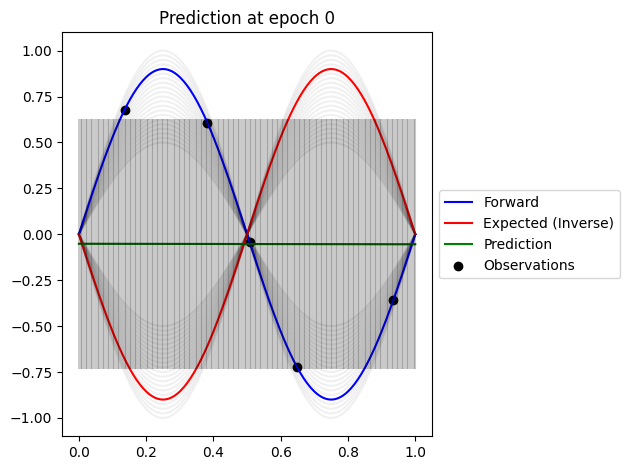

Saving model  0
loss:  22.267909408775683
latent loss:  20.729516749167452
Saving model with latent error  0
loss:  22.267909408775683
tensor([22.0732], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([21.8362], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([21.6440], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([21.4490], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([21.2115], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([20.9269], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([20.7551], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([20.5078], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([20.3036], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([20.0743], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([19.8438], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([19.7105], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([19.4204], dtype=torch.float64, grad_fn=<NormBackward1>)
tensor([19.2415], dtype=torch.flo

KeyboardInterrupt: 

In [396]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

EPOCHS = 500000
learning_rate = 1e-4

train()

In [393]:
best_model = dual_enc_dec_cnmp.DualEncoderDecoder(d_x, d_y1, d_y2).double()
best_model.load_state_dict(torch.load('inverse_best_model_latent.pth'))

/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_54457/1301593403.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('invers

<All keys matched successfully>

In [ ]:
importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)

t = 0.25
min_y_f = np.min(Y1[:, int(t * time_len)])
max_y_f = np.max(Y1[:, int(t * time_len)])
interval_y_f = np.linspace(min_y_f-0.1, max_y_f+0.1, 20)

min_y_i = np.min(Y2[:, int(t * time_len)])
max_y_i = np.max(Y2[:, int(t * time_len)])
interval_y_i = np.linspace(min_y_i-0.1, max_y_i+0.1, 20)

# plot latent losses
plt.plot(errors_with_latent)
plt.show()

i = 0
for idx in interval_y_f:
    condition_points = [[t, idx]]
    means, stds = dual_enc_dec_cnmp.predict_inverse(best_model, 1, time_len, condition_points, d_x, d_y1, d_y2, demo_data)
    if i == 0:
        utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = True)
        i += 1
    utils.plot_results(means, stds, Y1, Y2, idx, condition_points, errors, losses, time_len, d_N, plot_errors = False)


(60, 2)
(60, 2)
(4, 15, 2)


/var/folders/63/kw9gvntx3hzftcn6fp7wkf0c0000gn/T/ipykernel_54457/769751495.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


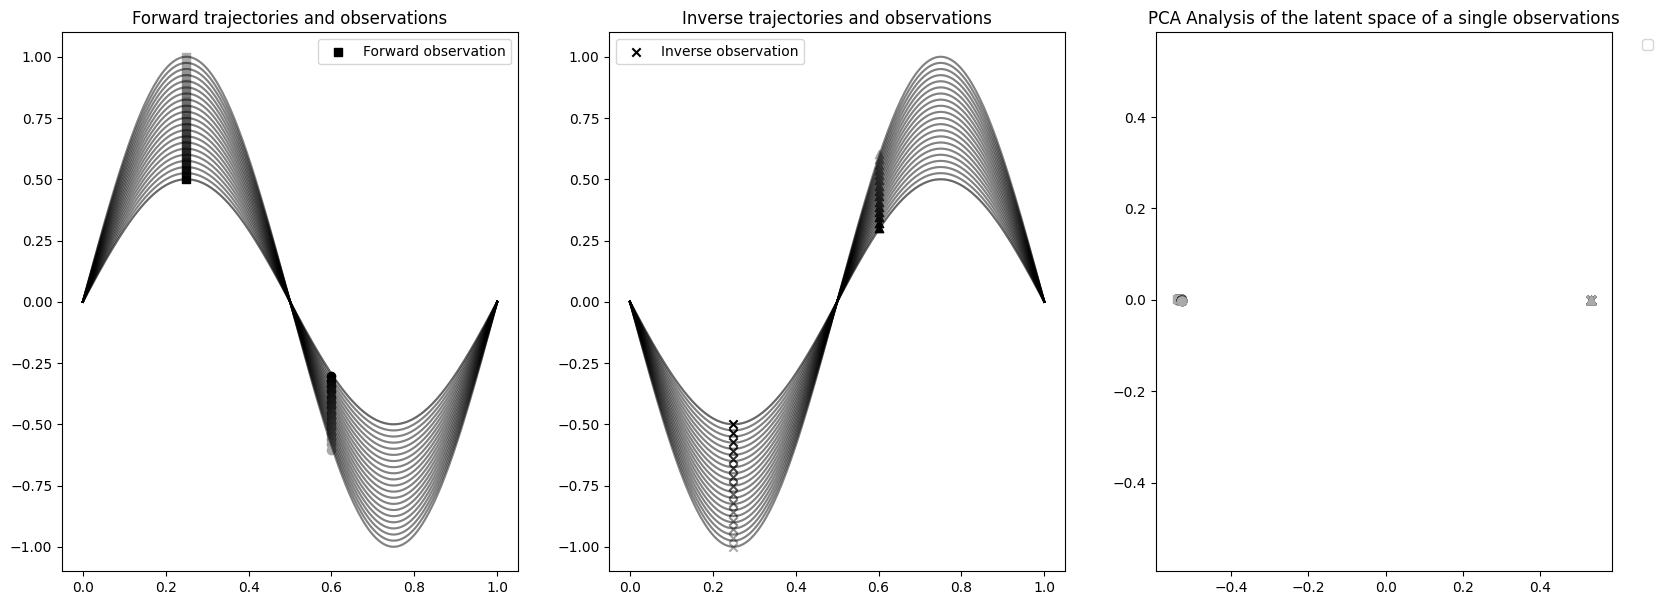

In [394]:

importlib.reload(dual_enc_dec_cnmp)
importlib.reload(utils)
from mpl_toolkits.mplot3d import Axes3D
from sympy import intervals


time = [0.25, 0.6]

## do the same for t = 0.25 and t = 0.75, obtain the pca result for all the points

intervals_y_f = []
intervals_y_i = []

all_observations_f = []  
all_observations_i = []


NUM_STEP = 15

for t in time:
    min_y_f = np.min(Y1[:, int(t * time_len)])
    max_y_f = np.max(Y1[:, int(t * time_len)])
    interval_y_f = np.linspace(min_y_f, max_y_f, NUM_STEP)
    if t > 0.5:
        interval_y_f = np.flip(interval_y_f)
    intervals_y_f.append(interval_y_f)

    min_y_i = np.min(Y2[:, int(t * time_len)])
    max_y_i = np.max(Y2[:, int(t * time_len)])
    interval_y_i = np.linspace(min_y_i, max_y_i, NUM_STEP)
    if t < 0.5:
        interval_y_i = np.flip(interval_y_i)
    intervals_y_i.append(interval_y_i)

    for idx in interval_y_f:
        condition_points = [[t, idx]]
        all_observations_f.append(condition_points)
    for idx in interval_y_i:
        condition_points = [[t, idx]]
        all_observations_i.append(condition_points)

all_observations_f = torch.tensor(all_observations_f).double()
all_observations_i = torch.tensor(all_observations_i).double()

pca_result = dual_enc_dec_cnmp.plot_latent_space(best_model, all_observations_f, all_observations_i) # [ft0, ft1, ... , it0, it1, ...]

## open 2 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 7))


for forward_traj in Y1:
    axs[0].plot(np.linspace(0, 1, time_len), forward_traj, c='black', alpha=0.2)
for inverse_traj in Y2:
    axs[1].plot(np.linspace(0, 1, time_len), inverse_traj, c='black', alpha=0.2)
axs[0].set_title("Forward trajectories and observations")
axs[1].set_title("Inverse trajectories and observations")

for i in range(len(intervals_y_f)):
    for j in range(len(intervals_y_f[i])):
        if i == 0 and j == 0:
            axs[0].scatter(time[i], intervals_y_f[i][j], marker="s", c=f"{(j)/(1.4*len(interval_y_f))}", label='Forward observation')
        else:
            if i == 0:
                axs[0].scatter(time[i], intervals_y_f[i][j], marker="s", c=f"{(j)/(1.4*len(interval_y_f))}")
            else:
                axs[0].scatter(time[i], intervals_y_f[i][j], c=f"{(j)/(1.4*len(interval_y_f))}")

for i in range(len(intervals_y_i)):
    for j in range(len(intervals_y_i[i])):
        if i == 0 and j == 0:
            axs[1].scatter(time[i], intervals_y_i[i][j], marker="x", c=f"{(j)/(1.4*len(interval_y_i))}", label='Inverse observation')
        else:
            if i == 0:
                axs[1].scatter(time[i], intervals_y_i[i][j], marker="x", c=f"{(j)/(1.4*len(interval_y_i))}")
            else:
                axs[1].scatter(time[i], intervals_y_i[i][j], marker="^", c=f"{(j)/(1.4*len(interval_y_i))}")

axs[0].legend()
axs[1].legend()

print(pca_result.shape)
pca_result = np.array(pca_result)
pca_result = pca_result.reshape((len(time)*2,-1,2))
print(pca_result.shape)

dict_markers = {0:'s', 1:'o', 2:'x', 3:'^'}

for i in range(len(pca_result)):
    for j in range(len(pca_result[i])):
        axs[2].scatter(pca_result[i][j][0], pca_result[i][j][1], marker = dict_markers[i], c=f"{(j)/(1.4*len(intervals_y_f[i%len(time)]))}")


## make x and y axis equal
axs[2].set_ylim(axs[2].get_xlim())
    

plt.title("PCA Analysis of the latent space of a single observations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

